In [1]:
import os
import cv2
import numpy as np
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

### Preprocessing

In [2]:
TEST_IMG_DIR = "data/ShanghaiTech/part_A/test_data/images"
TEST_GT_DIR  = "data/ShanghaiTech/part_A/test_data/ground-truth"
OUTPUT_IMG_DIR = "processed_test_images"
OUTPUT_DEN_DIR = "processed_test_density"

os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_DEN_DIR, exist_ok=True)

In [3]:
TARGET_SIZE = (512, 512)

In [4]:
def load_points(mat_path):
    mat = sio.loadmat(mat_path)
    points = mat["image_info"][0][0][0][0][0]
    return points

In [5]:
def create_density_map(points, h, w, sigma=4):
    impulse = np.zeros((h, w), dtype=np.float32)
    for x, y in points:
        if 0 <= int(y) < h and 0 <= int(x) < w:
            impulse[int(y), int(x)] = 1
    density = gaussian_filter(impulse, sigma=sigma)
    return density

In [7]:
print("Processing test images...")

for img_name in tqdm(os.listdir(TEST_IMG_DIR)):
    if img_name.endswith(".jpg"):
        img_path = os.path.join(TEST_IMG_DIR, img_name)
        mat_path = os.path.join(TEST_GT_DIR, "GT_"+img_name.replace(".jpg", ".mat"))

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img_resized = cv2.resize(img_rgb, TARGET_SIZE)
        cv2.imwrite(os.path.join(OUTPUT_IMG_DIR, img_name), cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

        # Density map generation
        points = load_points(mat_path)
        den = create_density_map(points, img.shape[0], img.shape[1])

        # Downscale by 8
        den = cv2.resize(den, (TARGET_SIZE[0]//8, TARGET_SIZE[1]//8))
        den = den * 64  # preserve count

        # Save
        np.save(os.path.join(OUTPUT_DEN_DIR, img_name.replace(".jpg", ".npy")), den)

print("Test preprocessing completed successfully!")

Processing test images...


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:26<00:00,  7.00it/s]

Test preprocessing completed successfully!


### Visualization of preprocessed data

In [17]:
import matplotlib.pyplot as plt

In [18]:
TEST_IMG_DIR = "processed_test_images"
TEST_DEN_DIR = "processed_test_density"

In [21]:
# taking first file to visualization
sample_img = os.listdir(TEST_IMG_DIR)[0]  # first file
print("Showing:", sample_img)

Showing: IMG_1.jpg


In [23]:
# loading image and density map
img_path = os.path.join(TEST_IMG_DIR, sample_img)
den_path = os.path.join(TEST_DEN_DIR, sample_img.replace(".jpg", ".npy"))

density_map = np.load(den_path)

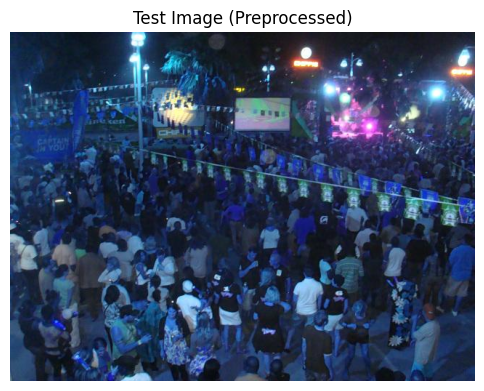

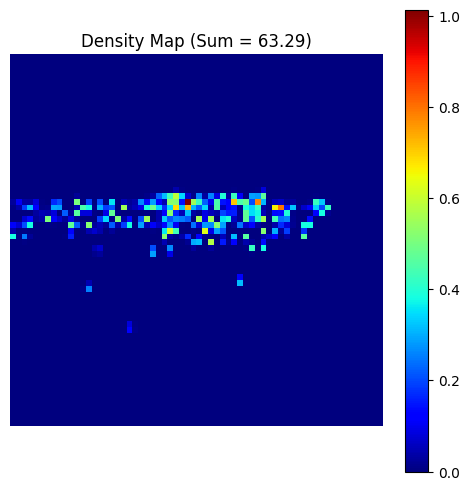

In [24]:
# Visualize image
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Test Image (Preprocessed)")
plt.axis("off")
plt.show()

# Visualize density map
plt.figure(figsize=(6,6))
plt.imshow(density_map, cmap="jet")
plt.title(f"Density Map (Sum = {density_map.sum():.2f})")
plt.colorbar()
plt.axis("off")
plt.show()

### Heatmap Overlay Visualization

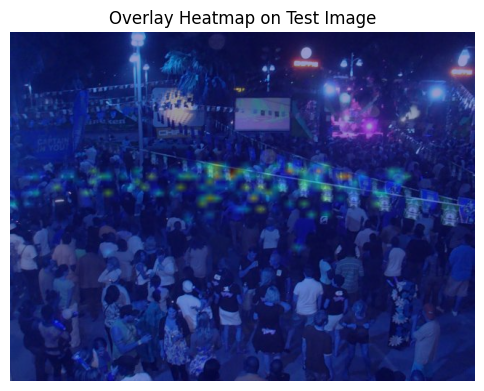

In [26]:
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

overlay = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Overlay Heatmap on Test Image")
plt.axis("off")
plt.show()